In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from root_numpy import root2array
import Constants as C
from WeightTool import WeightTool
from matplotlib.colors import LogNorm

from PlotTool import PlotTool
from Cuts import qratio, getQAB, qlayerCut

In [2]:
# Specify file paths
f_numu = '../trees/NuGen_11069_Nov5_999files.root'
f_cor  = '../trees/Corsika_11362_Nov9_wCor_3465files.root'

# Branches to load
branches = ['NPE','Nch','ImpLF_zen','cos(ImpLF_zen)','ImpLF_rchi2', 
            'nuE','NEvents','OneWeight',
            'cor_Weight','cor_DiplopiaWeight','cor_Polygonato',
            'cor_TimeScale',
            'passHESE','q_out0','q_out1','q_out2','q_in',
            'hs_z_travel','totalQ',
            'log10(hs_q_tot_pulses)', 'hm_nhit_doms','hm_nhit_strings',
            'honda2006_nue','sarcevic_std_nue',
            'honda2006_gaisserH3a_elbert_v2_numu', 
            'sarcevic_max_gaisserH3a_elbert_numu',
            'InteractionType',
            #'Qearly5','tearly5','StrNearly5','DomNearly5',
            #'Qlarge5','risetimelarge5','widthlarge5','tlarge5',
            #'xlarge5','ylarge5','zlarge5',
            #'xearly5','yearly5','zearly5',
            #'StrNlarge5','DomNlarge5', 
            'rho_travel_q', 'rho_travel',
            't_onstring','q_largest-q_onstring','t_largest-t_onstring',
            'tearly','tlarge',
            ]

# Add any selection
sel = '(NPE>1000)'

# Load the data
d_numu = root2array(f_numu,treename="tree",branches=branches,selection=sel+'&&(nuE>0)')
d_cor  = root2array(f_cor,treename="tree",branches=branches+['corsika_wcor'],selection=sel)

# Calcualte the weights
w_tool = WeightTool()
w_numuE2 = w_tool.getAstroW(d_numu['nuE'], d_numu['OneWeight'], 
                            d_numu['NEvents'], C.nugen_numu_nfiles)
w_cor    = w_tool.getCorsikaW(d_cor['cor_Weight'], 
                              d_cor['cor_DiplopiaWeight'], 
                              d_cor['cor_Polygonato'],
                              d_cor['cor_TimeScale'],
                              C.cor_nfiles,
                              d_cor['corsika_wcor'])
w_atmos  = w_tool.getAtmosW(d_numu['OneWeight'],
                            d_numu['honda2006_gaisserH3a_elbert_v2_numu'],
                            d_numu['NEvents'],
                            C.nugen_numu_nfiles)
w_atmos += w_tool.getAtmosW(d_numu['OneWeight'],
                            d_numu['sarcevic_max_gaisserH3a_elbert_numu'],
                            d_numu['NEvents'],
                            C.nugen_numu_nfiles)

# Put data into data frame
d_numu = pd.DataFrame(d_numu)
d_cor  = pd.DataFrame(d_cor)

# Add weights
d_numu['wE2'] = pd.Series(w_numuE2)
d_cor['w']  = pd.Series(w_cor)
d_numu['w'] = pd.Series(w_atmos)

In [3]:
# Break data set into inner and outter portions
d_numu_in  = qlayerCut(d_numu, True, 0.8)
d_numu_out = qlayerCut(d_numu, False, 0.8)
d_cor_in   = qlayerCut(d_cor, True, 0.8)
d_cor_out  = qlayerCut(d_cor, False, 0.8)

print "NuGen Inner:   ", sum(d_numu_in['wE2']), "Outer: ", sum(d_numu_out['wE2'])
print "Corsika Inner: ", sum(d_cor_in['w']), "Outer: ", sum(d_cor_out['w'])

NuGen Inner:    19.8481687869 Outer:  17.0244205524
Corsika Inner:  16089115.7358 Outer:  7903256.52772


In [4]:
# To make things easier for plotting make dictionary
info = {'data' : [d_cor_in, d_numu_in, d_numu_in,
                  d_cor_out, d_numu_out, d_numu_out],
        'col' : ['r','g','b','m','y','c'],
        'lbl' : [r'Atmos. $\mu$ (in)',
                 r'Atmos. $\nu_{\mu}$ (in)', 
                 r'Astro. $\nu_{\mu}$ (in)', 
                 r'Atmos. $\mu$ (out)',
                 r'Atmos. $\nu_{\mu}$ (out)', 
                 r'Astro. $\nu_{\mu}$ (out)'],
        'ls'  : ['solid','solid','solid','dashed','dashed','dashed'],
        'w'   : ['w','w','wE2','w','w','wE2']
        }

In [5]:
# Simple method to plot basic vars
def plot(info, var, xl, nbins, xmin, xmax, logy, ysf=1e-10):
    fig, ax = plt.subplots(ncols=1,figsize=(7,6))
    ymax = -9999
    for i in range(len(info['data'])):
        dt  = info['data'][i]
        col = info['col'][i]
        lbl = info['lbl'][i]
        ls  = info['ls'][i]
        w   = info['w'][i]
        bc, bins, p = plt.hist(dt[var].as_matrix(),
                               weights=dt[w].as_matrix(),
                               bins=nbins, range=(xmin,xmax),
                               color=col, label=lbl, lw=1.5,
                               histtype='step', ls = ls
                               )
        
        plt.xlabel(xl)
        plt.ylabel(C.lt_label)
        plt.tight_layout()
    
        if bc.max() > ymax:
            ymax = bc.max()
    
    if logy:
        ax.set_yscale('log')
        plt.ylim([ymax*ysf,5*ymax])
    plt.legend(loc='best',fontsize='medium')
    plt.grid()

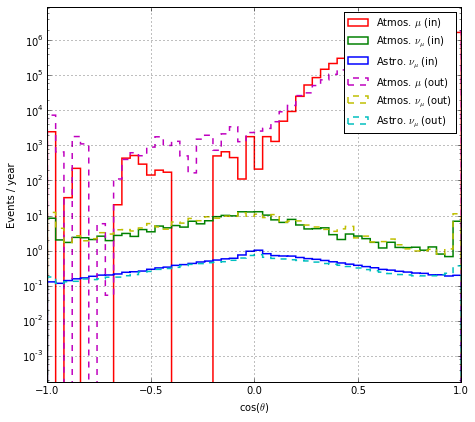

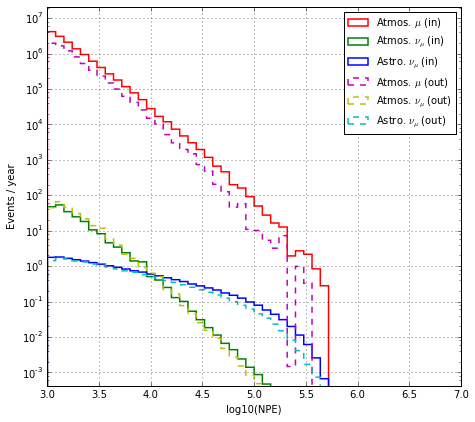

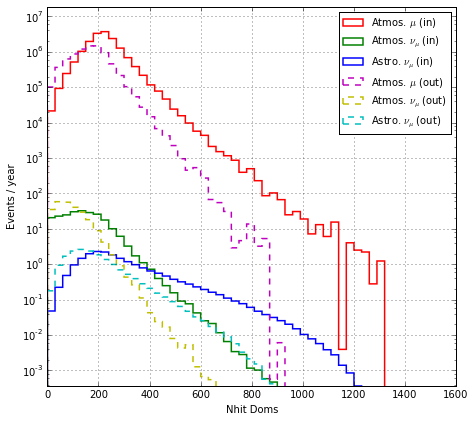

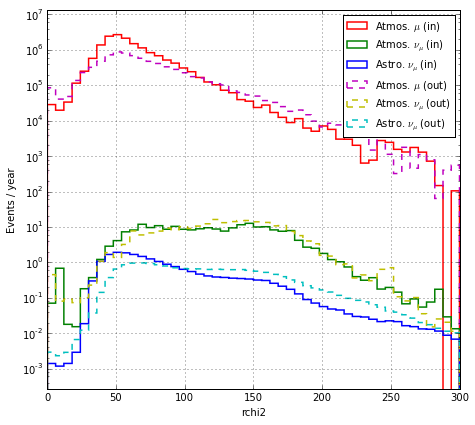

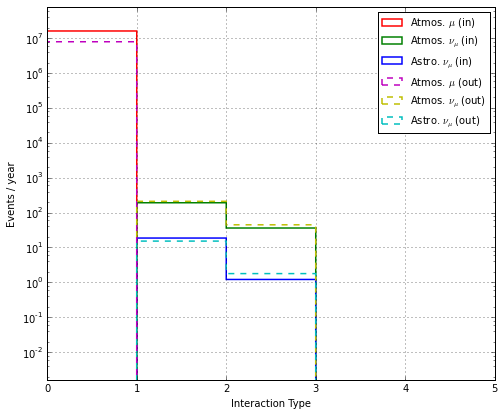

In [6]:
# Ok so now we are at the starting point for the EHE online alert. From
# here we normally proceed with the total combined event counts. What might
# be interesting is if we can change the cuts and get more events for outer
# and inner events, given larger energy events should deposit more charge
# based on how close/far it is away from the detector.

#Plot some basic variables
plot(info, 'cos(ImpLF_zen)',r'cos($\theta$)',50,-1,1,True)
plot(info,'log10(hs_q_tot_pulses)','log10(NPE)',50,3,7,True)
plot(info,'hm_nhit_doms','Nhit Doms',50,0,1500,True)
plot(info,'ImpLF_rchi2','rchi2',50,0,300,True)
plot(info,'InteractionType','Interaction Type',5,0,5,True)
plt.show()


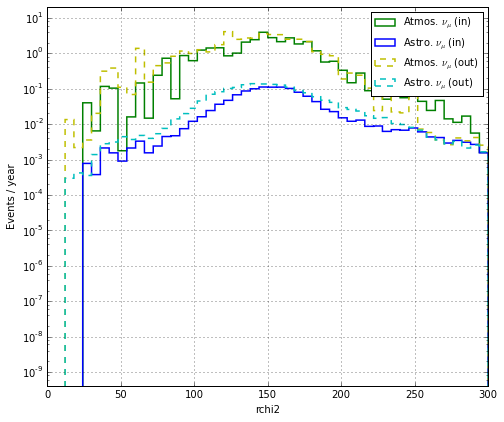

In [7]:
# I want to make this a track sample, so let's purify by cutting
# on improved line fit, similar to before. Do we need to cut as harshly?
# From looking at nu_e events we can get some idea that < 80 did a good
# job, but maybe we can be a little looser.  What do CC events look like?

dt_in = d_numu_in[ d_numu_in['InteractionType'] == 2 ]
dt_out = d_numu_out[ d_numu_out['InteractionType'] == 2 ]

temp = {'data' : [dt_in, dt_in,
                  dt_out, dt_out],
        'col' : ['g','b','y','c'],
        'lbl' : [r'Atmos. $\nu_{\mu}$ (in)', 
                 r'Astro. $\nu_{\mu}$ (in)', 
                 r'Atmos. $\nu_{\mu}$ (out)', 
                 r'Astro. $\nu_{\mu}$ (out)'],
        'ls'  : ['solid','solid','dashed','dashed'],
        'w'   : ['w','wE2','w','wE2']
        }

plot(temp,'ImpLF_rchi2','rchi2',50,0,300,True)

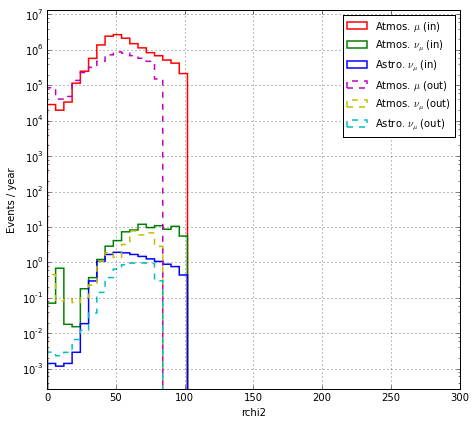

In [8]:
# Interestingly from the plot above the outer events have a lower fit quality!
# This seems to make sense though. For a cascade that is more contained, we will 
# have more hit DOMs that don't follow the track hypothesis.  So for outer events,
# we just have less hit Doms.  
# So let's cut:
#    * Inner events: < 100
#    * Outer events: < 80

def cutrchi2(data, cutval):
    return data[ data['ImpLF_rchi2'] < cutval]

# Loop and apply cut
for i in range(len(info['data'])):
    cval = 100
    if 'out' in info['lbl'][i]:
        cval = 80
    info['data'][i] = cutrchi2(info['data'][i],cval)

# Plot to make sure
plot(info,'ImpLF_rchi2','rchi2',50,0,300,True)


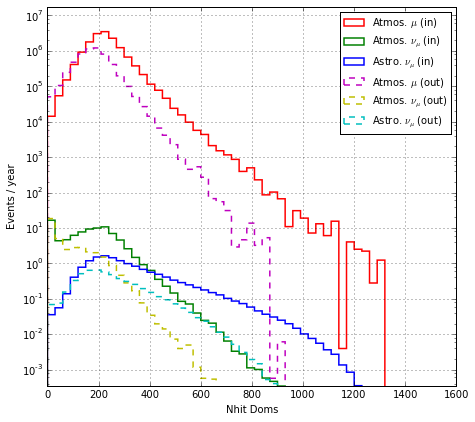

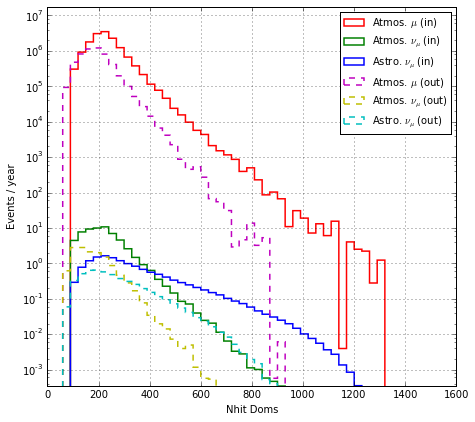

In [9]:
# The next cut will be on the number of Hit Doms
plot(info,'hm_nhit_doms','Nhit Doms',50,0,1500,True)

# So after looking it seems cutting at 100 is easy enough
def cutndom(data, cutval):
    return data[ data['hm_nhit_doms'] > cutval]

# Loop and apply cut
for i in range(len(info['data'])):
    cval = 100
    if 'out' in info['lbl'][i]:
        cval = 80
    info['data'][i] = cutndom(info['data'][i],cval)

# Plot and show the result
plot(info,'hm_nhit_doms','Nhit Doms',50,0,1500,True)

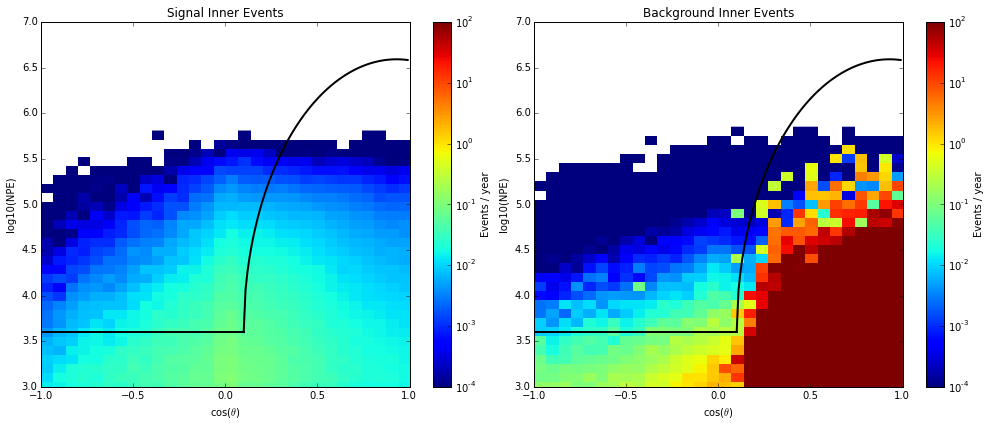

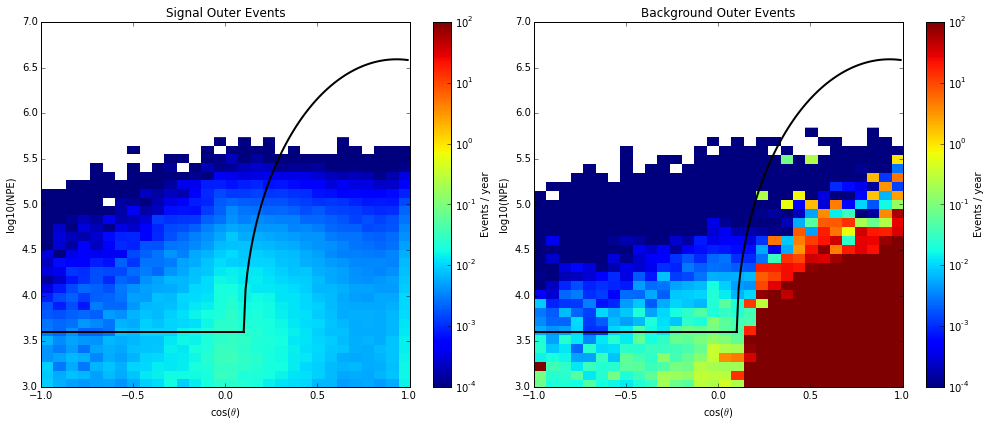

In [40]:
# Ok we are essentially ready for the 2D optimization, Let's
# Take a look at the distributions

# Combine corsika and atmos nu
d_bkg_in  = pd.concat([info['data'][0],info['data'][1]])
d_bkg_out = pd.concat([info['data'][3],info['data'][4]])

# Pick out astro numu
d_sig_in  = info['data'][2]
d_sig_out = info['data'][5]

# Plot constants
nbins = 30
xmin  = -1
xmax  = 1
ymin  = 3
ymax  = 7
zmin  = 1e-4
zmax  = 1e2

# Create a plot tool for 2D plots
pt = PlotTool()
 
# Method to draw previous cuts
def drawCuts(axis):
    axis.plot([-1,0.1], [3.6,3.6], c='black', lw=2)
    def f(x):
        return 3.6 + 2.99 * np.sqrt(np.fabs(1-np.power((x-0.93)/0.83,2)))
    step = 0.01
    x = np.arange(0.1,1,step)
    axis.plot(x,f(x),c='black',lw=2)
              
    
   
# Plot 2D for inner
fig, ax = plt.subplots(ncols=2,figsize=(14,6))

ax[0].set_title("Signal Inner Events")
pt.ploth2(d_sig_in['cos(ImpLF_zen)'].as_matrix(),
        d_sig_in['log10(hs_q_tot_pulses)'].as_matrix(),
        d_sig_in['wE2'].as_matrix(), 
        r'cos($\theta$)',
        'log10(NPE)',
        C.lt_label,
        nbins,xmin,xmax,ymin,ymax,zmin,zmax,
        False,
        ax[0])

ax[1].set_title("Background Inner Events")
pt.ploth2(d_bkg_in['cos(ImpLF_zen)'].as_matrix(),
         d_bkg_in['log10(hs_q_tot_pulses)'].as_matrix(),
         d_bkg_in['w'].as_matrix(), 
         r'cos($\theta$)',
         'log10(NPE)',
         C.lt_label,
         nbins,xmin,xmax,ymin,ymax,zmin,zmax,
         False,
         ax[1])
drawCuts(ax[0])
drawCuts(ax[1])

# Plot 2D for inner
fig, ax = plt.subplots(ncols=2,figsize=(14,6))

ax[0].set_title("Signal Outer Events")
pt.ploth2(d_sig_out['cos(ImpLF_zen)'].as_matrix(),
        d_sig_out['log10(hs_q_tot_pulses)'].as_matrix(),
        d_sig_out['wE2'].as_matrix(), 
        r'cos($\theta$)',
        'log10(NPE)',
        C.lt_label,
        nbins,xmin,xmax,ymin,ymax,zmin,zmax,
        False,
        ax[0])

ax[1].set_title("Background Outer Events")
pt.ploth2(d_bkg_out['cos(ImpLF_zen)'].as_matrix(),
         d_bkg_out['log10(hs_q_tot_pulses)'].as_matrix(),
         d_bkg_out['w'].as_matrix(), 
         r'cos($\theta$)',
         'log10(NPE)',
         C.lt_label,
         nbins,xmin,xmax,ymin,ymax,zmin,zmax,
         False,
         ax[1])
drawCuts(ax[0])
drawCuts(ax[1])



In [ ]:
# The discrepancies above from what I normally show is that we are missing
# some higher energy simulation as I haven't been processing it because
# I am focused on the 1 PeV region.  So in this sense I think I can now
# Reoptimize and potentially gain some more events